In [1]:
import telegram
import numpy as np
import pandas as pd
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
from datetime import datetime, timedelta
from read_db.CH import Getch

Отчет должен состоять из двух частей:

текст с информацией о значениях ключевых метрик за предыдущий день <br>
график с значениями метрик за предыдущие 7 дней <br>
Отобразите в отчете следующие ключевые метрики: 

- DAU 
- Просмотры
- Лайки
- CTR

In [2]:
bot =telegram.Bot(token='5037017955:AAGRp8733t4gl2Ow3cqsmrYP7XtzkcwKatg')
# chat_id = -777972833 -личный чат
chat_id = -708816698 # симулятор аналитика

In [3]:
#updates = bot.getUpdates()

#print(updates[-1])

In [4]:
yesterday = datetime.now() - timedelta(1)
week_ago = datetime.now() - timedelta(7)

In [5]:
# DAU за предыдущий день
query_dau = '''select (today()- 1) as Date,
                      uniq(user_id) as UNIQ_USERS
               from simulator.feed_actions
               where toDate(time) = today()- 1
         
'''
# Просмотры за предыдущий день
query_views = ''' select (today() - 1) as Date,
                         countIf(action='view') as VIEWS
                  from simulator.feed_actions
                  where toDate(time) = today() - 1    
'''
# Лайки за предыдущий день
query_likes = ''' select (today() - 1) as Date,
                        countIf(action='like') as LIKES
                  from simulator.feed_actions
                  where toDate(time) = today() - 1    
'''
# CTR за предыдущий день 
query_ctr = ''' select (today() - 1) as Date,
                       round(countIf(action='like') / countIf(action='view') *100, 2) as "CTR"
                from simulator.feed_actions
                where toDate(time) = today() - 1    
'''

DAU = Getch(query_dau).df
Views = Getch(query_views).df
Likes = Getch(query_likes).df
CTR = Getch(query_ctr).df

day = DAU.Date.dt.date
users = DAU.UNIQ_USERS
views = Views.VIEWS
likes = Likes.LIKES
ctr = CTR['CTR']

msg = f'Доброе утро! Актуальные данные на {yesterday:%d.%m.%Y} по News Feed. \
        \n \
        \nЗа {yesterday:%d.%m.%Y}  \
        \nкол-во уникальных пользователей:   {users[0]:,.0f} \
        \nкол-во просмотров:   {views[0]:,.0f} \
        \nкол-во просмотров лайков:   {likes[0]:,.0f} \
        \nCTR:   {ctr[0]}%'

print(msg)
bot.sendMessage(chat_id=chat_id, text=msg)


Доброе утро! Актуальные данные на 10.12.2021 по News Feed.         
         
За 10.12.2021          
кол-во уникальных пользователей:   18,887         
кол-во просмотров:   489,772         
кол-во просмотров лайков:   95,539         
CTR:   19.51%


/tmp/ipykernel_57/3769234412.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabel)


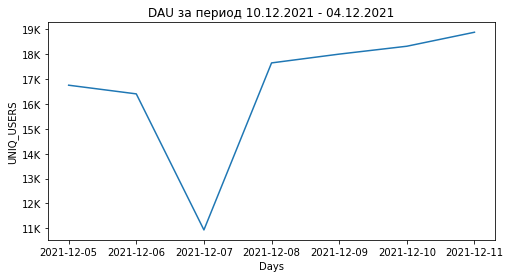

In [6]:
# график с DAU за последние 7 дней

query = '''select toDate(time) as Days, 
                  uniq(user_id) as UNIQ_USERS
           from simulator.feed_actions
           where  Days > today() - 8 and  Days != today() 
           group by toDate(time)
        '''
DAU = Getch(query).df

plt.figure(figsize=(8,4))
g = sns.lineplot(x='Days', y='UNIQ_USERS', data=DAU)
ylabel = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
g.set_yticklabels(ylabel)
plt.title(f'DAU за период {yesterday:%d.%m.%Y} - {week_ago:%d.%m.%Y}')
plt.show()

plot_object = io.BytesIO()
plt.savefig(plot_object)

plot_object.name = 'UNIQ_USERS.png'
plot_object.seek(0)

plt.close()

bot.sendPhoto(chat_id=chat_id, photo=plot_object)

/tmp/ipykernel_57/2160708883.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g1.set_yticklabels(g1_ylabel)
/tmp/ipykernel_57/2160708883.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g2.set_yticklabels(g2_ylabel)


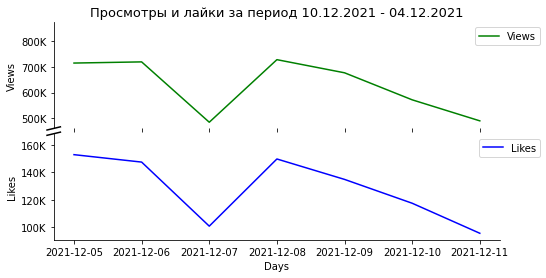

In [7]:
# график Likes, Views за последние 7 дней
query = '''select toDate(time) as Days, 
                  countIf(action='like') as Likes,
                  countIf(action='view') as Views             
            from simulator.feed_actions
            where  Days > today() - 8 and  Days != today() 
            group by toDate(time)
        '''
likes_views = Getch(query).df
likes_views

fig, (ax_top, ax_bottom) = plt.subplots(ncols=1, nrows=2, figsize=(8,4), sharex=True,gridspec_kw={'hspace':0.05})

g1 = sns.lineplot(data=likes_views, x='Days', y='Likes', color='blue', ax=ax_bottom)
g2 = sns.lineplot(data=likes_views, x='Days', y='Views', color='green', ax=ax_top)
ax_top.set_ylim(likes_views['Views'].min()*0.95, likes_views['Views'].max()*1.2)
ax_bottom.set_ylim(likes_views['Likes'].min()*0.95, likes_views['Likes'].max()*1.1)

g1_ylabel = ['{:,.0f}'.format(x) + 'K' for x in g1.get_yticks()/1000]
g1.set_yticklabels(g1_ylabel)
g2_ylabel = ['{:,.0f}'.format(x) + 'K' for x in g2.get_yticks()/1000]
g2.set_yticklabels(g2_ylabel)

sns.despine(ax=ax_bottom)
sns.despine(ax=ax_top, bottom=True)

ax = ax_top
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

ax2 = ax_bottom
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax_bottom.legend(labels=['Likes'], bbox_to_anchor=(0.6, 0.5, 0.5, 0.5))
ax_top.legend(labels=['Views'], bbox_to_anchor=(0.6, 0.5, 0.5, 0.5))
ax_top.set_title(f'Просмотры и лайки за период {yesterday:%d.%m.%Y} - {week_ago:%d.%m.%Y}', fontsize=13)
plt.show()

plot_object = io.BytesIO()
plt.savefig(plot_object)

plot_object.name = 'Actions.png'
plot_object.seek(0)

plt.close()

bot.sendPhoto(chat_id=chat_id, photo=plot_object)


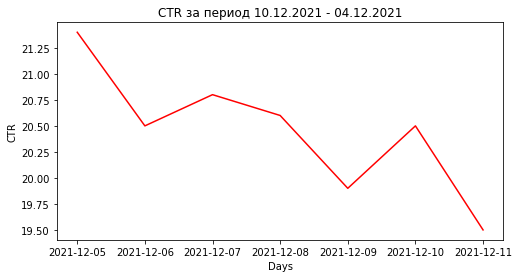

In [8]:
#CTR
query_ctr = '''select toDate(time) as Days, 
                  round(countIf(action='like') / countIf(action='view')* 100,1) as CTR                
              from simulator.feed_actions
              where  Days > today() - 8 and  Days != today() 
              group by toDate(time)
        '''
ctr = Getch(query_ctr).df

plt.figure(figsize=(8,4))
g = sns.lineplot(data=ctr, x='Days', y='CTR', color='red')
#ylabel = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/1000]
#g.set_yticklabels(ylabel)

plt.title(f'CTR за период {yesterday:%d.%m.%Y} - {week_ago:%d.%m.%Y}')
plt.show()

plot_object = io.BytesIO()
plt.savefig(plot_object)

plot_object.name = 'Actions_CTR.png'
plot_object.seek(0)

plt.close()

bot.sendPhoto(chat_id=chat_id, photo=plot_object)